In [19]:
import random
from copy import deepcopy
from math import log10

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.axes import Axes

In [20]:
def stake_transformation(values, slope, curvature, threshold):
    transformed_stakes = []

    for x in values:
        if x <= 30e3:
            transformed_stakes.append(0.0001)
        elif x <= threshold:
            f_x = slope * x
            transformed_stakes.append(f_x)
        else:
            g_x = slope * threshold + (x - threshold) ** (1 / curvature)
            transformed_stakes.append(g_x)

    return transformed_stakes

def compute_probabilities(stakes: list):
    sum_stakes = sum(stakes)
    return [s / sum_stakes for s in stakes]

def compute_rewards(probabilities: list, budget: int):
    return [p * budget for p in probabilities]

def compute_apy(opt: dict, data: list, percentage: bool = False):
    transformed_stakes = stake_transformation(data, **opt["model_arguments"])

    probabilities = compute_probabilities(transformed_stakes)

    rewards = compute_rewards(probabilities, opt["budget"])

    period_apy = [r / s for r, s in zip(rewards, transformed_stakes)]
    yearly_apy = [apy * 12 / opt["period_in_months"] for apy in period_apy]
    
    apy = sum(yearly_apy) / len(yearly_apy)

    if percentage:
        return apy * 100
    
    return apy

def factor_and_prefix(value):
    factor = int(int(log10(value))/3)*3
    if factor < 3:
        prefix = ""
    elif factor < 6:
        prefix = "k"
    elif factor < 9:
        prefix = "M"

    return 10**factor, prefix

def probabilistic_apy(datas: list[list], options: list[dict], steps:int = 100):
    result_template = {"apys": [], "average": 0}

    results = [deepcopy(result_template) for _ in range(len(options))]

    for idx, opt in enumerate(options):
        for _ in range(steps):
            stakes = sum([random.sample(data, count) for data, count in zip(datas, opt["data_count"])], [])

            tf_stakes = stake_transformation(stakes, **opt["model_arguments"])
            
            apy = compute_apy(opt, tf_stakes, percentage=False)

            results[idx]["apys"].append(apy)

        results[idx]["average"] = np.mean(results[idx]["apys"])
        results[idx]["std"] = np.std(results[idx]["apys"])

    return results

def generate_simulation_graph(datas:list[list], options: list[dict], steps: int = 200, title: str = None):
    cols = 3
    rows = int(len(options) / cols + 0.5)
    if rows * cols < len(options):
        rows += 1
        
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6,rows*4), dpi=300)

    axes = [axes] if isinstance(axes, Axes) else axes.flatten()

    results = probabilistic_apy(datas, options, steps)


    for opt, result, ax in zip(options, results, axes):
        max_stakes = max([max(data) for data, count in zip(datas, opt["data_count"]) if count])
        stakes = np.linspace(0, max_stakes, 1000)
        factor, prefix = factor_and_prefix(stakes[-1])
        
        tf_stakes = stake_transformation(stakes, **opt["model_arguments"])

        data_points = sum([random.sample(data, count) for data, count in zip(datas, opt["data_count"])], [])
        tf_data_points = stake_transformation(data_points, **opt["model_arguments"])

        stakes_for_plt = [s/factor for s in stakes]
        tf_stakes_for_plt = [s/factor for s in tf_stakes]

        data_points_for_plt = [s/factor for s in data_points]
        tf_data_points_for_plt = [s/factor for s in tf_data_points]
        
        messages_per_second = opt["budget"] / (opt["ticket_options"]["price"] * opt["ticket_options"]["winning_probability"]) / (opt["period_in_months"] * 30 * 24 * 60 * 60)


        ax.plot(stakes_for_plt, tf_stakes_for_plt, label=opt["legend"])
        ax.scatter(data_points_for_plt, tf_data_points_for_plt, s=12, alpha=0.8, c="#ff7f0e")

        ax.set_xlabel(f"Staking (/{prefix}/HOPR)")
        ax.set_ylabel(f"Transformed Staking (/{prefix}/HOPR)")
        ax.text(0.9,
                0.2,
                f"APY: {result['average']:.2%} (+- {result['std']:.2%})",
                transform=ax.transAxes, 
                horizontalalignment='right', 
                bbox=dict(facecolor='red', alpha=0.5),)
        ax.text(0.9,
                0.1,
                f"Messages/s: {messages_per_second:.2f}",
                transform=ax.transAxes, 
                horizontalalignment='right', 
                bbox=dict(facecolor='blue', alpha=0.5),)
      
        ax.legend()
        ax.grid()

    if title:
        fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [21]:
raw_all = pd.read_csv("all_01H7Z22K1VRTXCWJJJFV2A64VP.csv", low_memory=False)
raw_nft = pd.read_csv("nft_01H7Z2W99SMWJ01YN552WSRADV.csv", low_memory=False)

raw_data = pd.merge(raw_all, raw_nft, on="account", how="left")

condition = raw_data["token_id"].isnull()

staking_info_nft_holders = list(raw_data[~condition]["actual_stake"])
staking_info_non_nft_holders = list(raw_data[condition]["actual_stake"])
staking_info_all = list(raw_data["actual_stake"])

datas = [staking_info_nft_holders, staking_info_non_nft_holders, [500_000]]

### Economic model

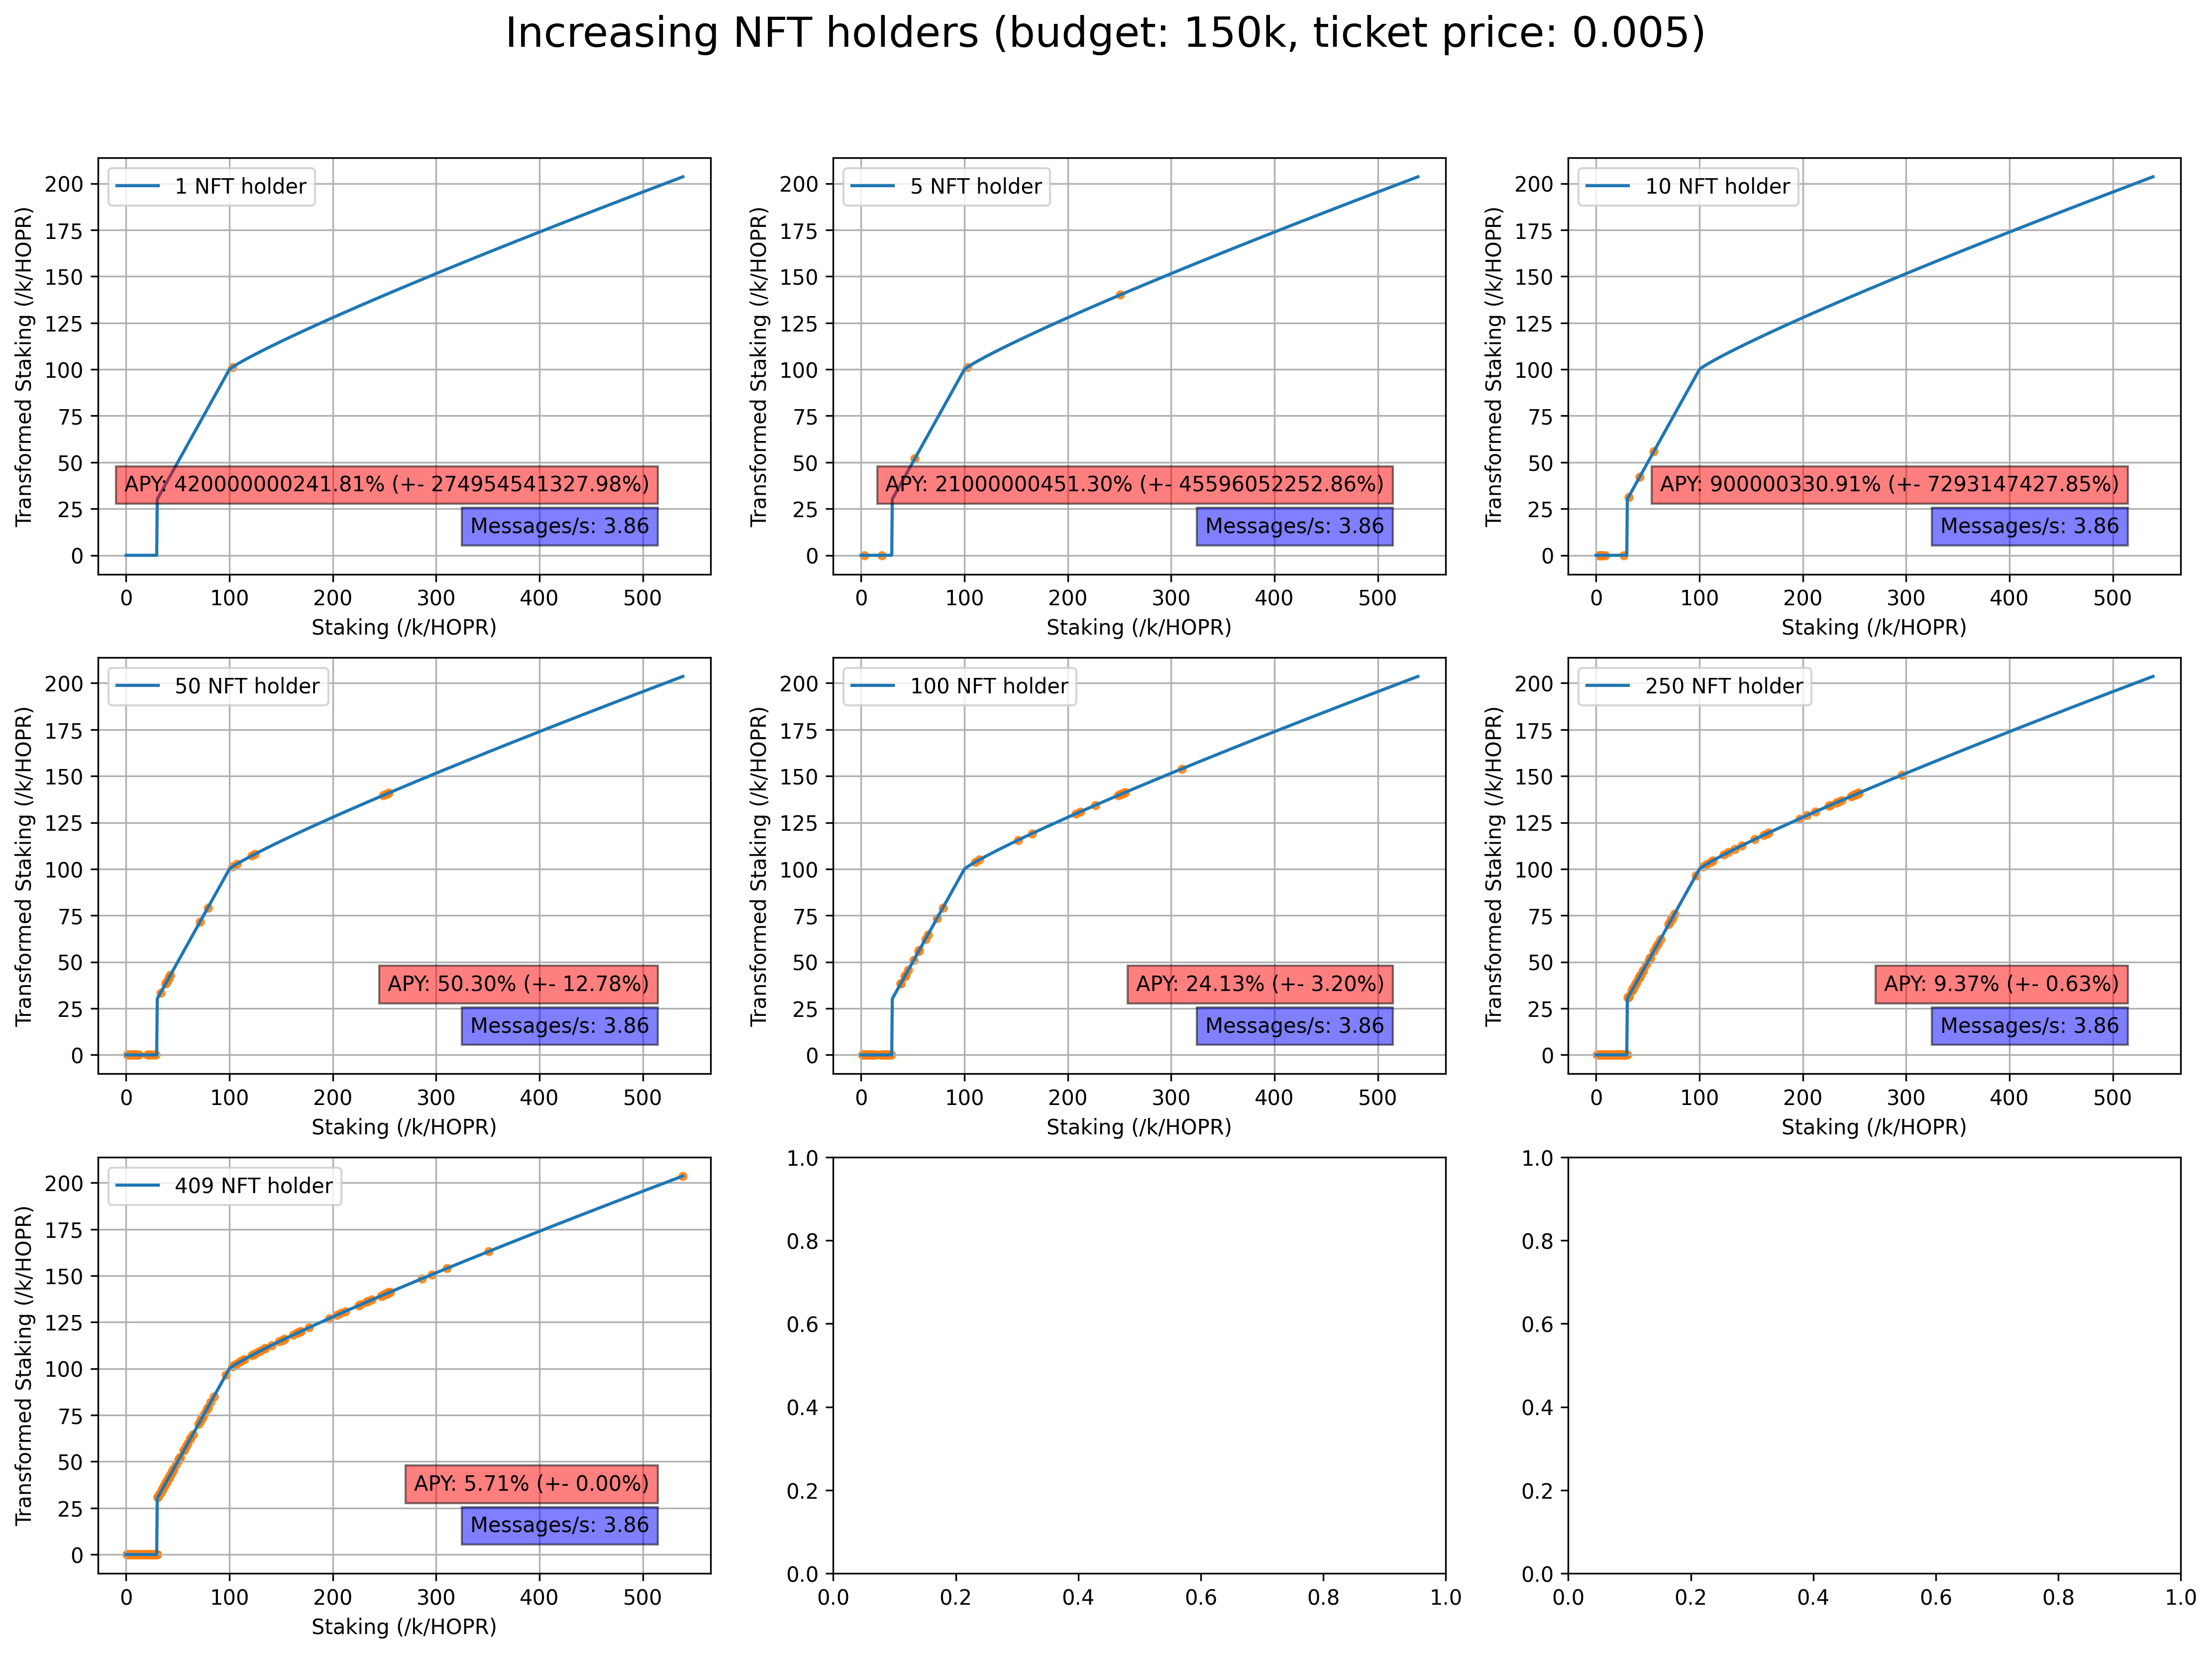

In [22]:
options = [{
    "data_count": [1, 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": "1 NFT holder"
},
{
    "data_count": [5, 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": "5 NFT holder"
},
{
    "data_count": [10, 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": "10 NFT holder"
},
{
    "data_count": [50, 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": "50 NFT holder"
},
{
    "data_count": [100, 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": "100 NFT holder"
},
{
    "data_count": [250, 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": "250 NFT holder"
},
{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": f"{len(staking_info_nft_holders)} NFT holder"
},
]

generate_simulation_graph(datas, options, title="Increasing NFT holders (budget: 150k, ticket price: 0.005)")

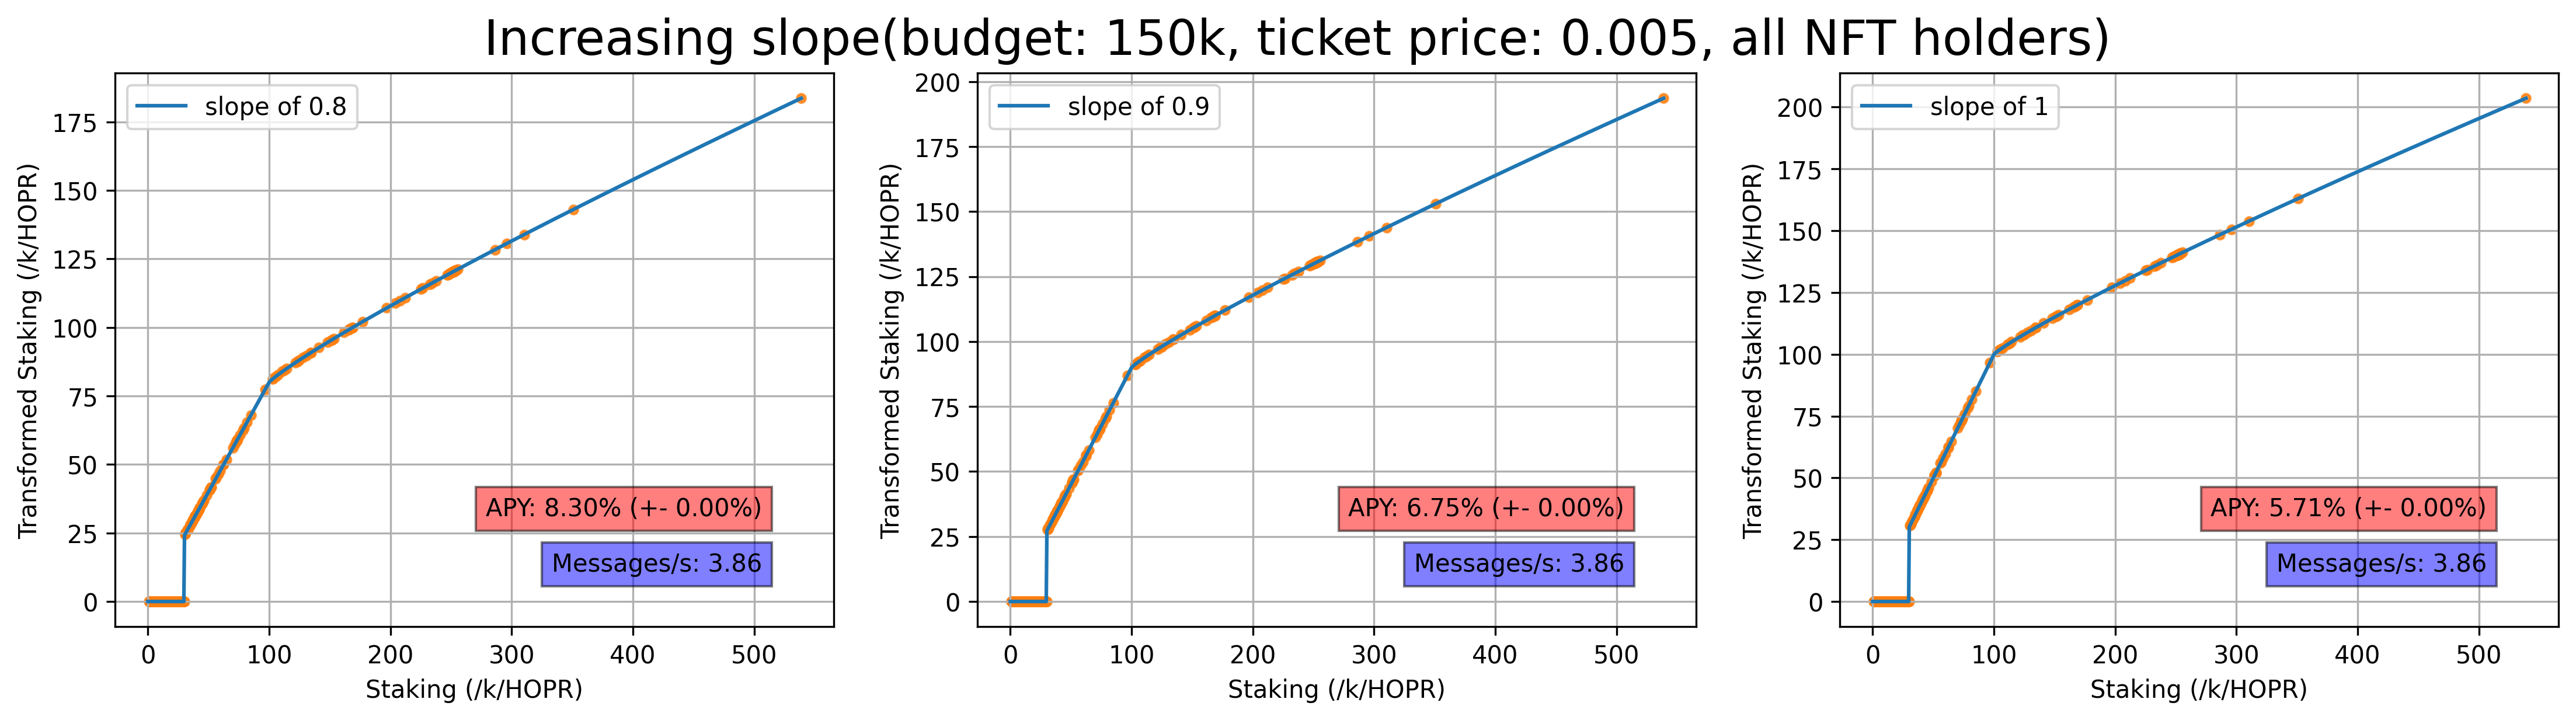

In [23]:
options = [{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 0.8,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": "slope of 0.8"
},
{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 0.9,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": "slope of 0.9"
},
{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": "slope of 1"
}
]

generate_simulation_graph(datas, options, 200, title="Increasing slope(budget: 150k, ticket price: 0.005, all NFT holders)")

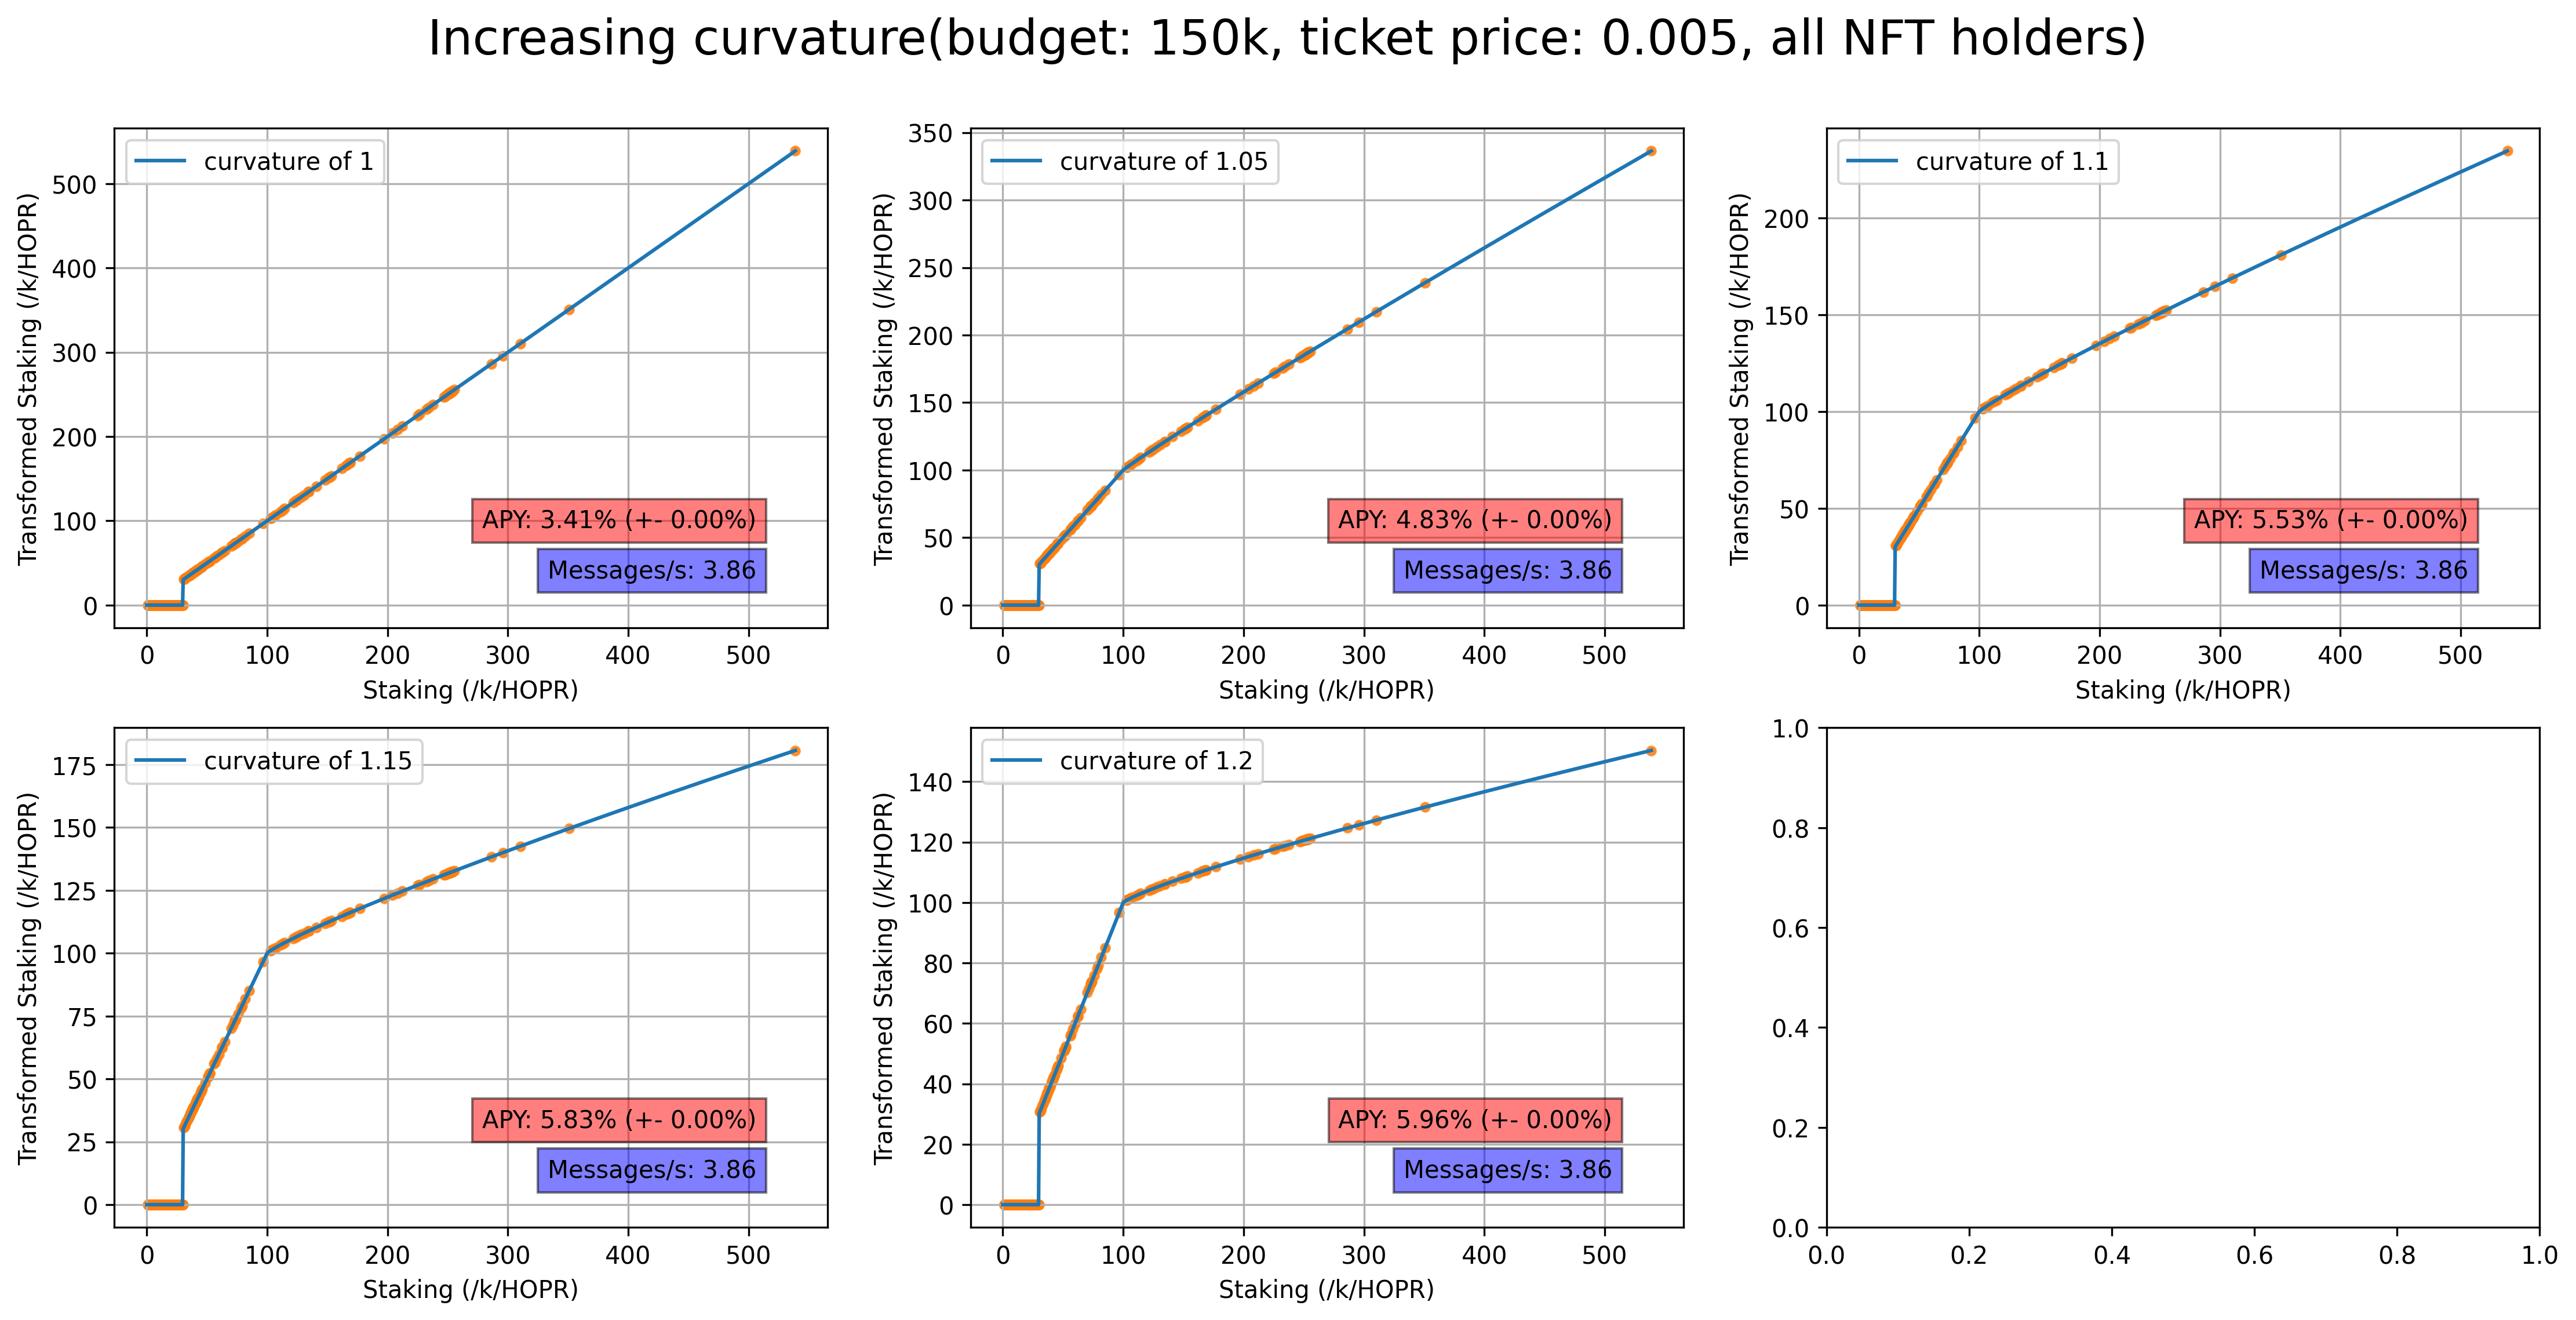

In [24]:
options = [{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": "curvature of 1"
},
{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.05,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": "curvature of 1.05"
},
{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.1,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": "curvature of 1.1"
},
{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.15,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": "curvature of 1.15"
},
{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.2,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": "curvature of 1.2"
}
]

generate_simulation_graph(datas, options, 200, title="Increasing curvature(budget: 150k, ticket price: 0.005, all NFT holders)")

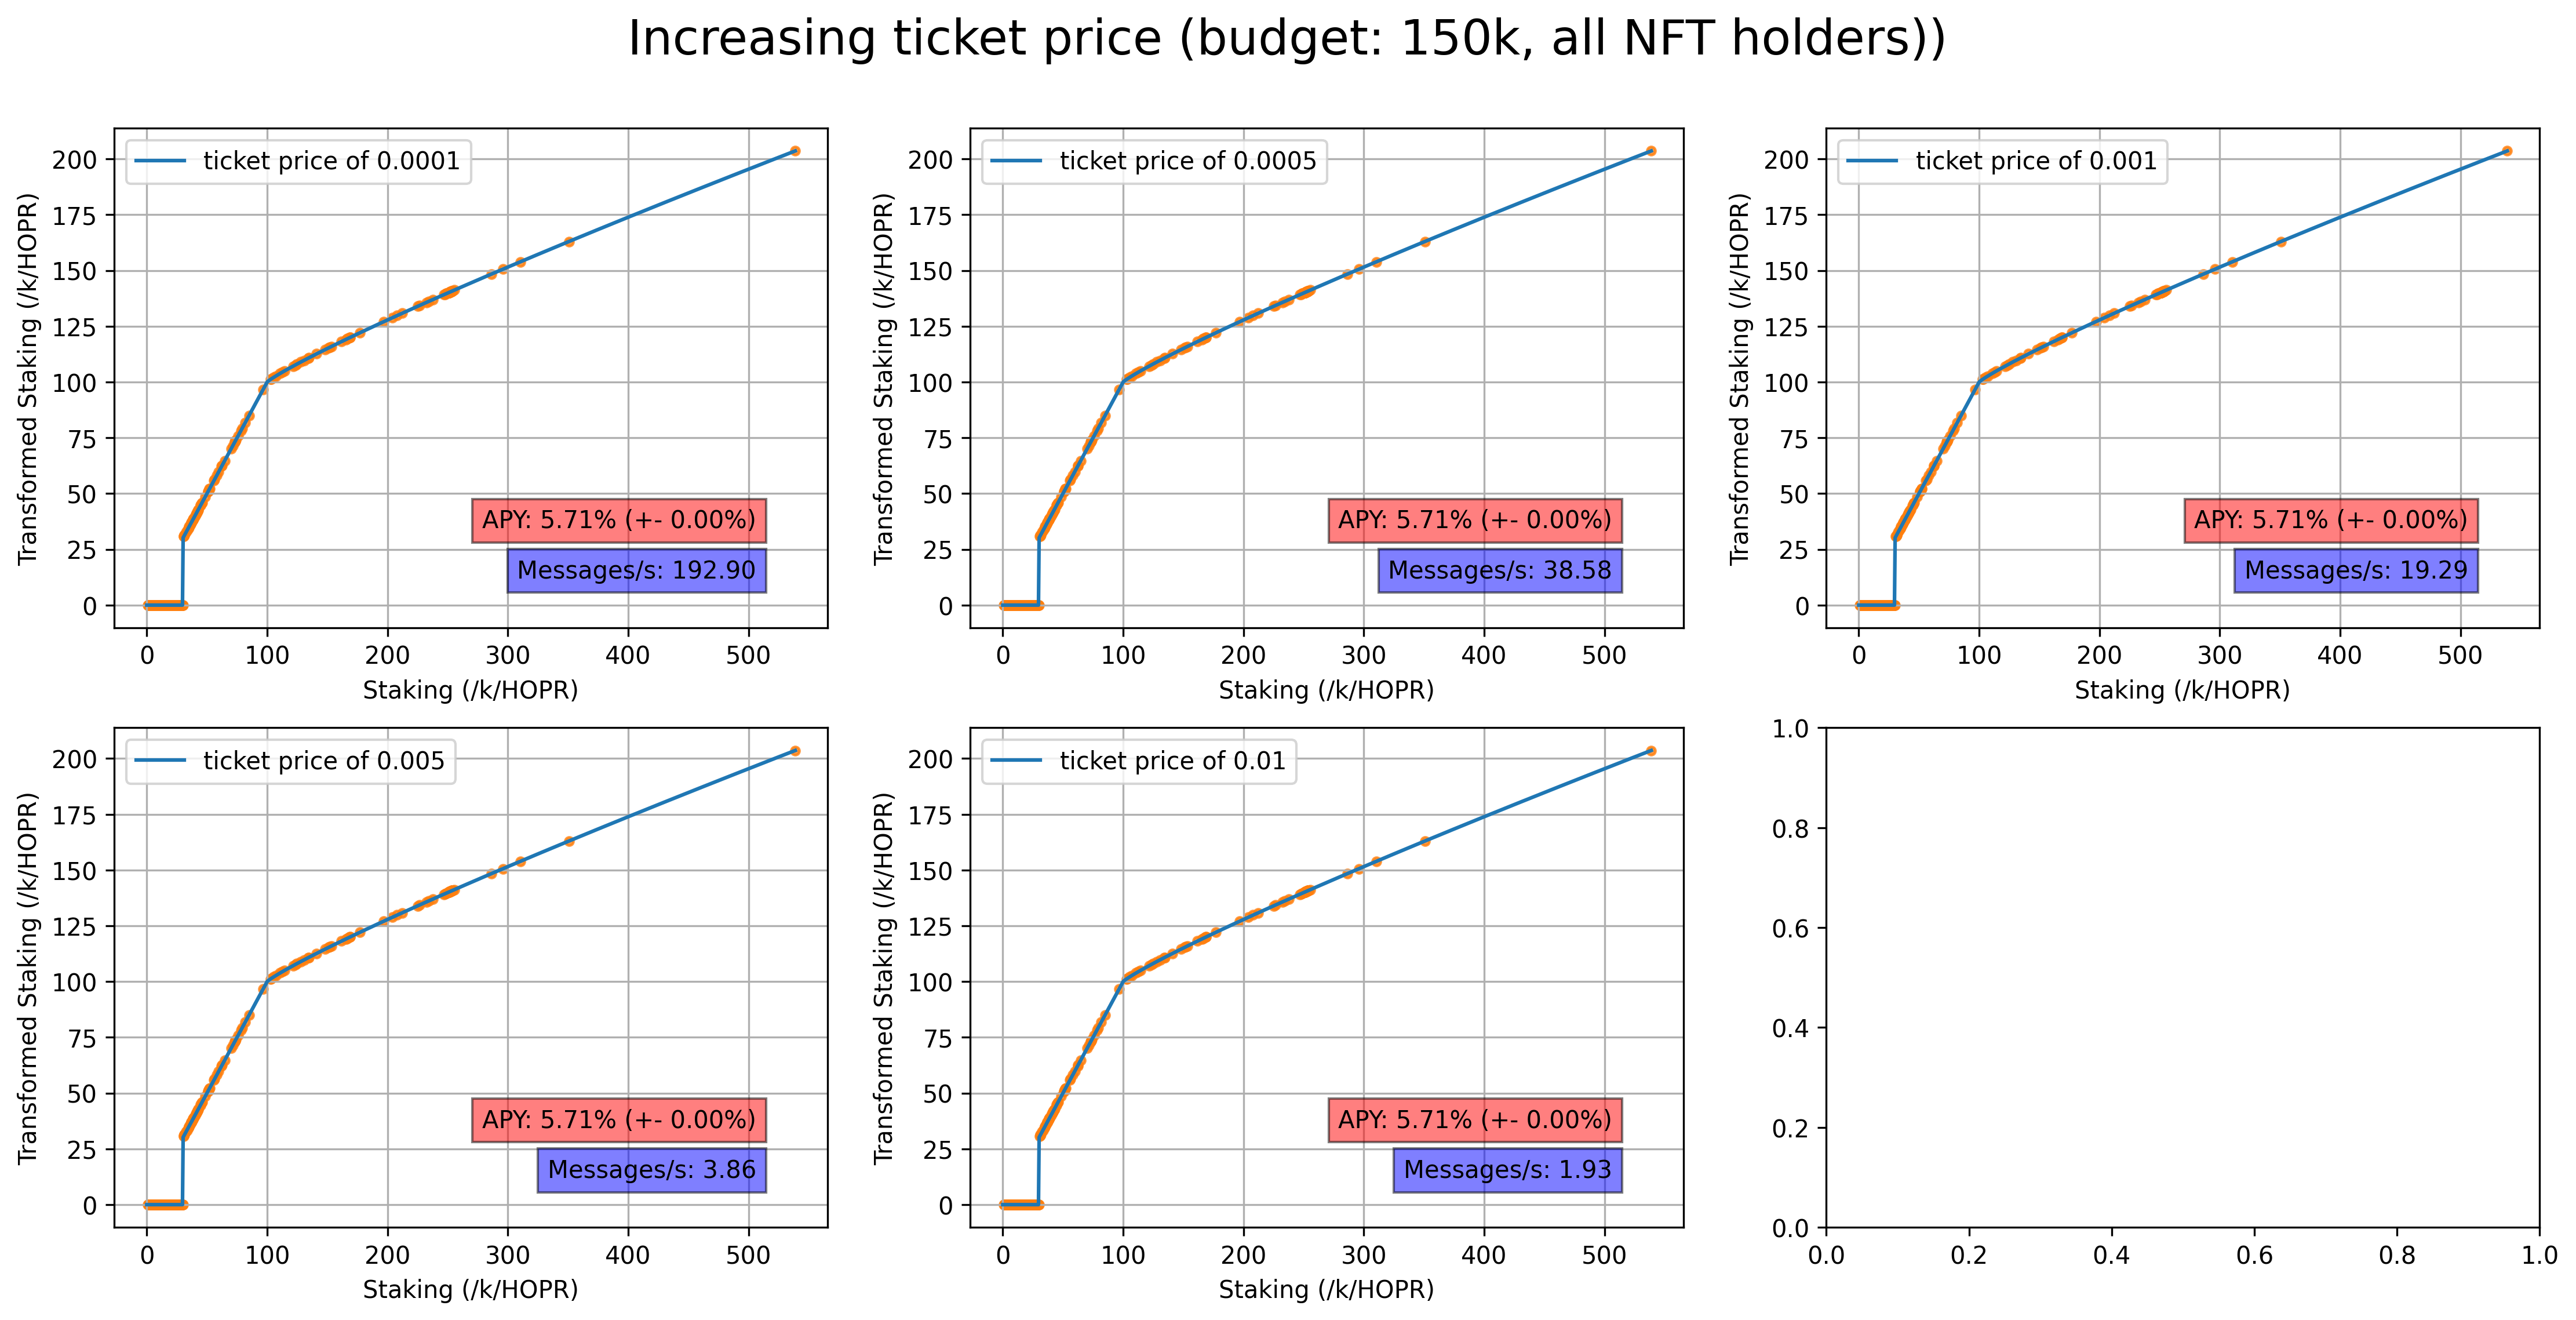

In [25]:
options = [{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.0001,
        "winning_probability": 1,
    },
    "legend": "ticket price of 0.0001"
},
{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.0005,
        "winning_probability": 1,
    },
    "legend": "ticket price of 0.0005"
},
{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.001,
        "winning_probability": 1,
    },
    "legend": "ticket price of 0.001"
},
{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.005,
        "winning_probability": 1,
    },
    "legend": "ticket price of 0.005"
},
{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.01,
        "winning_probability": 1,
    },
    "legend": "ticket price of 0.01"
}
]

generate_simulation_graph(datas, options, title="Increasing ticket price (budget: 150k, all NFT holders))")

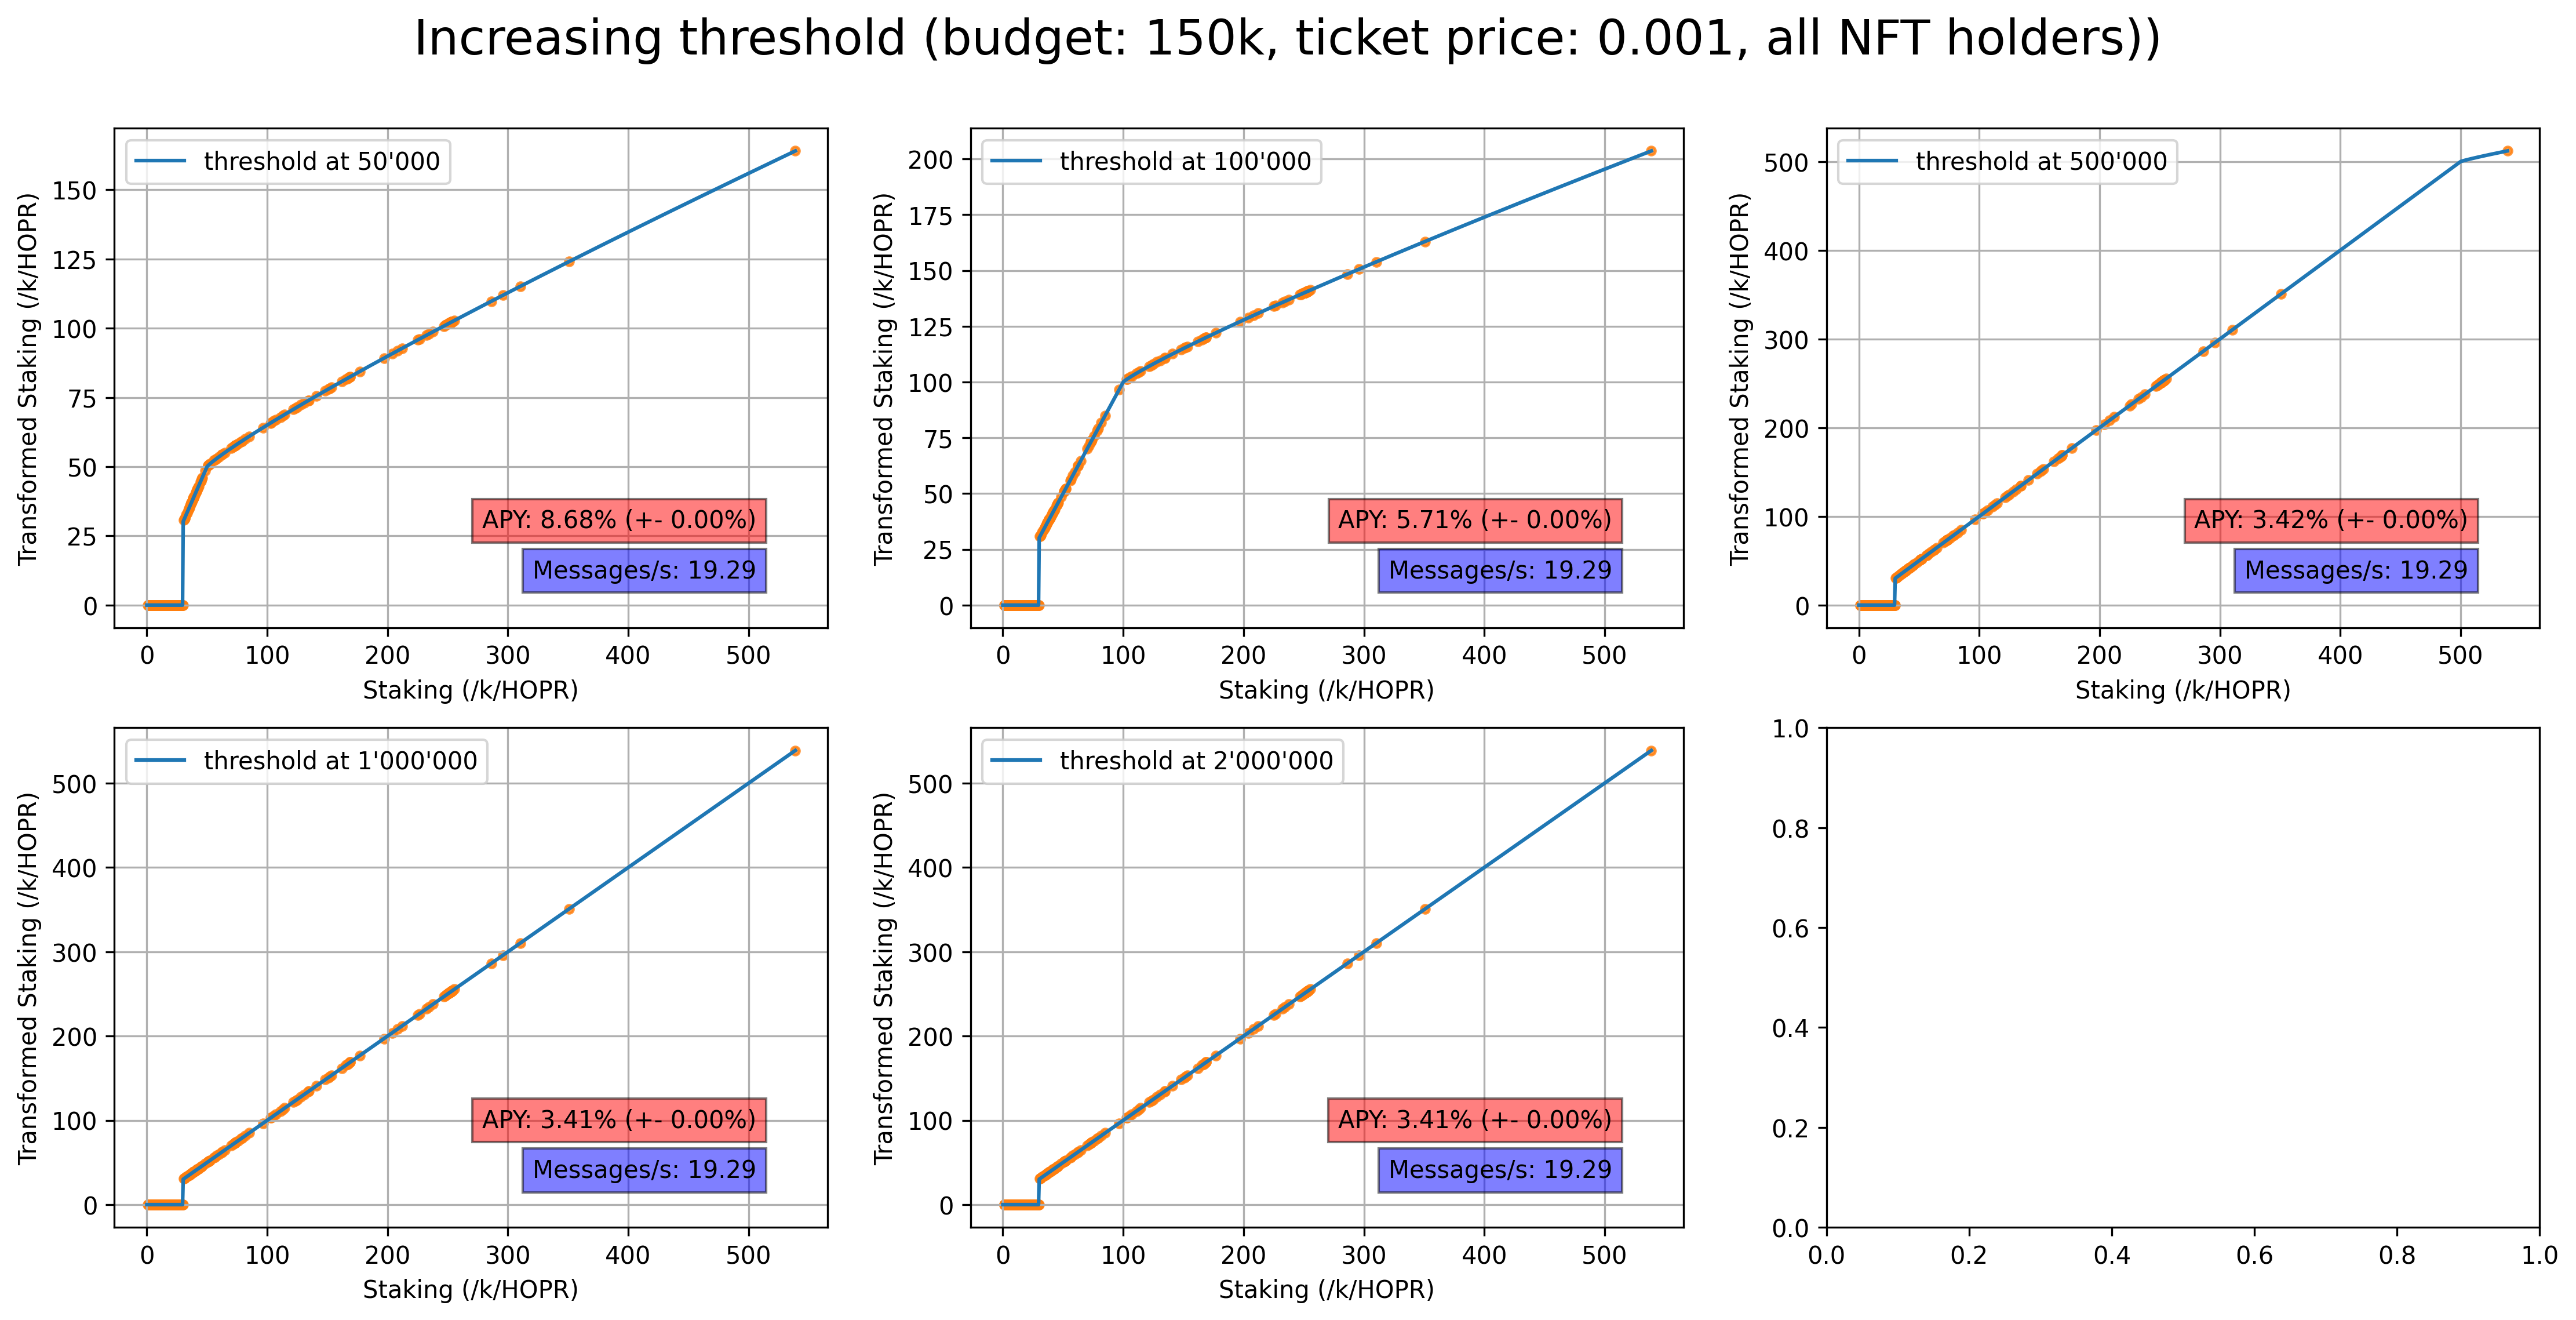

In [26]:
options = [{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":50e3,
    },
    "ticket_options": {
        "price": 0.001,
        "winning_probability": 1,
    },
    "legend": "threshold at 50'000"
},
{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.001,
        "winning_probability": 1,
    },
    "legend": "threshold at 100'000"
},
{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":500e3,
    },
    "ticket_options": {
        "price": 0.001,
        "winning_probability": 1,
    },
    "legend": "threshold at 500'000"
},
{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":1e6,
    },
    "ticket_options": {
        "price": 0.001,
        "winning_probability": 1,
    },
    "legend": "threshold at 1'000'000"
},
{
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 150_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":2e6,
    },
    "ticket_options": {
        "price": 0.001,
        "winning_probability": 1,
    },
    "legend": "threshold at 2'000'000"
}
]

generate_simulation_graph(datas, options, title="Increasing threshold (budget: 150k, ticket price: 0.001, all NFT holders))")